# Unsupervised Learning  FLEXISAFE Beginners' Project: Customer Segmentation using K-means Clustering


## Table of Contents
- Project Overview
- Dataset Description
- Methodology
- Implementation
- Results
- Conclusion
Conclusion

## Project Overview <a name="project-overview"></a>

This project applies unsupervised learning techniques to perform customer segmentation using the K-means clustering algorithm. The goal is to identify distinct groups of customers based on their purchasing behavior from an e-commerce dataset from kaggle.

### Dataset Description <a name="dataset-description"></a>

We'll use the "Mall Customer Segmentation Data" from Kaggle, which contains information about customers' annual income, spending score, and other demographic features.

### Methodology <a name="methodology"></a>

Mathematical Formulation of K-means
K-means aims to partition n observations into k clusters where each observation belongs to the cluster with the nearest mean. The objective function is:

where:

- is the i-th cluster

- s the centroid of cluster

- is a data point

The algorithm minimizes this within-cluster sum of squares.

## Implementation <a name="implementation"></a>

In [26]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from scipy.spatial.distance import cdist
import warnings
import requests
from io import StringIO
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(1234)

In [27]:
def load_and_preprocess_data(url=None, file_path=None, numeric_features=None, 
                           categorical_features=None, id_column=None):
    """
    Robust function to load and preprocess datasets from various sources.
    
    Parameters:
    -----------
    url : str, optional
        URL to the raw dataset file (GitHub raw content URL)
    file_path : str, optional
        Local file path to the dataset
    numeric_features : list, optional
        List of numeric feature column names to use
    categorical_features : list, optional
        List of categorical feature column names to use
    id_column : str, optional
        Name of ID column to exclude from analysis
        
    Returns:
    --------
    tuple: (pd.DataFrame, np.ndarray)
        - Original dataframe
        - Scaled features numpy array
    """
    try:
        # Load the data
        if url:
            print(f"Attempting to load data from URL: {url}")
            
            # Check if it's a GitHub URL and needs to be converted to raw
            if 'github.com' in url and 'blob' in url:
                url = url.replace('github.com', 'raw.githubusercontent.com').replace('/blob/', '/')
                print(f"Converted to raw content URL: {url}")
            
            response = requests.get(url)
            response.raise_for_status()  # Raise error for bad status
            
            # Try reading with different encodings if needed
            try:
                df = pd.read_csv(StringIO(response.text))
            except UnicodeDecodeError:
                df = pd.read_csv(StringIO(response.text), encoding='latin1')
                
        elif file_path:
            print(f"Attempting to load data from file: {file_path}")
            # Try multiple file formats
            if file_path.endswith('.csv'):
                df = pd.read_csv(file_path)
            elif file_path.endswith(('.xls', '.xlsx')):
                df = pd.read_excel(file_path)
            else:
                raise ValueError("Unsupported file format")
        else:
            raise ValueError("Either url or file_path must be provided")
            
        print("\nDataset loaded successfully. Shape:", df.shape)
        print("\nFirst 5 rows:")
        print(df.head())
        
        # Basic data info
        print("\nData types:")
        print(df.dtypes)
        
        # Check for missing values
        print("\nMissing values:")
        print(df.isna().sum())
        
        # Automatic feature selection if not specified
        if numeric_features is None:
            numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
            if id_column and id_column in numeric_features:
                numeric_features.remove(id_column)
            print(f"\nAutomatically selected numeric features: {numeric_features}")
        
        # Handle categorical features
        if categorical_features:
            print(f"\nEncoding categorical features: {categorical_features}")
            df = pd.get_dummies(df, columns=categorical_features, drop_first=True)
            # Add encoded features to numeric features
            new_features = [col for col in df.columns if col.startswith(tuple(categorical_features))]
            numeric_features.extend(new_features)
        
        # Verify we have features to work with
        if not numeric_features:
            raise ValueError("No numeric features available for clustering")
        
        # Select features and scale them
        X = df[numeric_features]
        
        # Handle missing values if any exist
        if X.isna().sum().sum() > 0:
            print("\nHandling missing values with median imputation...")
            X = X.fillna(X.median())
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        print("\nPreprocessing completed successfully.")
        print(f"Final feature matrix shape: {X_scaled.shape}")
        
        return df, X_scaled
    
    except Exception as e:
        print(f"\nError in load_and_preprocess_data: {str(e)}")
        print("\nTroubleshooting tips:")
        print("- For GitHub URLs, make sure to use the 'raw' content URL")
        print("- Check if the file actually exists at the specified location")
        print("- Verify you have permission to access the resource")
        print("- If using a local file, check the file format and path")
        return None, None

In [2]:
def load_and_preprocess_data(url):
    """
    Load and preprocess the dataset from the given URL.
    
    Parameters:
    -----------
    url : str
        URL or path to the dataset file
        
    Returns:
    --------
    tuple: (pd.DataFrame, pd.DataFrame)
        - Original dataframe
        - Scaled features dataframe
    """
    try:
        # Load the dataset
        df = pd.read_csv(url)
        print("Dataset loaded successfully.")
        print(f"Shape of dataset: {df.shape}")
        print("\nFirst 5 rows:")
        print(df.head())
        
        # Basic data info
        print("\nDataset info:")
        print(df.info())
        
        # Check for missing values
        print("\nMissing values:")
        print(df.isnull().sum())
        
        # Select relevant features and scale them
        X = df[['Annual Income (k$)', 'Spending Score (1-100)']]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        return df, X_scaled
    
    except Exception as e:
        print(f"Error loading or preprocessing data: {e}")
        return None, None

In [4]:
def perform_clustering(X, n_clusters):
    """
    Perform K-means clustering with the specified number of clusters.
    
    Parameters:
    -----------
    X : array-like
        Scaled feature matrix
    n_clusters : int
        Number of clusters to form
        
    Returns:
    --------
    tuple: (KMeans, array)
        - Fitted KMeans model
        - Cluster labels
    """
    try:
        kmeans = KMeans(n_clusters=n_clusters, random_state=1234)
        labels = kmeans.fit_predict(X)
        
        print(f"\nCluster centers (scaled):")
        print(kmeans.cluster_centers_)
        
        print("\nCluster distribution:")
        unique, counts = np.unique(labels, return_counts=True)
        print(dict(zip(unique, counts)))
        
        return kmeans, labels
    
    except Exception as e:
        print(f"Error performing clustering: {e}")
        return None, None

In [5]:
def visualize_clusters(df, X_scaled, labels, cluster_centers):
    """
    Visualize the clusters and their characteristics.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Original dataframe
    X_scaled : array-like
        Scaled feature matrix
    labels : array
        Cluster labels
    cluster_centers : array
        Coordinates of cluster centers
        
    Returns:
    --------
    plt.Figure
        Figure containing cluster visualizations
    """
    try:
        # Create figure with subplots
        fig = plt.figure(figsize=(18, 12))
        
        # Scatter plot of clusters
        ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
        sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=labels, 
                        palette='viridis', s=60, ax=ax1)
        ax1.scatter(cluster_centers[:, 0], cluster_centers[:, 1], 
                   s=300, c='red', marker='X', label='Centroids')
        ax1.set_xlabel('Annual Income (scaled)')
        ax1.set_ylabel('Spending Score (scaled)')
        ax1.set_title('Customer Clusters')
        ax1.legend()
        
        # Original scale scatter plot
        ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1)
        sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', 
                        hue=labels, data=df, palette='viridis', s=60, ax=ax2)
        ax2.set_title('Customer Clusters (Original Scale)')
        
        # Boxplot of features by cluster
        df['Cluster'] = labels
        ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
        sns.boxplot(x='Cluster', y='Annual Income (k$)', data=df, ax=ax3)
        ax3.set_title('Annual Income Distribution by Cluster')
        
        plt.tight_layout()
        
        return fig
    
    except Exception as e:
        print(f"Error visualizing clusters: {e}")
        return None

In [6]:
def analyze_cluster_profiles(df, labels):
    """
    Analyze and print the characteristics of each cluster.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Original dataframe with cluster labels
    labels : array
        Cluster labels
    """
    try:
        # Add cluster labels to dataframe
        df['Cluster'] = labels
        
        # Calculate mean values for each cluster
        cluster_profiles = df.groupby('Cluster').agg({
            'Age': 'mean',
            'Annual Income (k$)': 'mean',
            'Spending Score (1-100)': 'mean',
            'CustomerID': 'count'
        }).rename(columns={'CustomerID': 'Count'})
        
        print("\nCluster Profiles:")
        print(cluster_profiles)
        
        # Calculate percentage of total customers
        cluster_profiles['Percentage'] = (cluster_profiles['Count'] / cluster_profiles['Count'].sum()) * 100
        
        return cluster_profiles
    
    except Exception as e:
        print(f"Error analyzing cluster profiles: {e}")
        return None

In [29]:
# Use the RAW GitHub content URL (not the web interface URL)
correct_url = "https://raw.githubusercontent.com/SteffiPeTaffy/machineLearningAZ/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2025%20-%20Hierarchical%20Clustering/Mall_Customers.csv"

In [33]:
# Specify the features we want to use for this dataset
numeric_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
categorical_features = ['Genre']
id_column = 'CustomerID'


In [34]:
# Load the data
df, X_scaled = load_and_preprocess_data(
    url=correct_url,
    numeric_features=numeric_features,
    categorical_features=categorical_features,
    id_column=id_column
)

Attempting to load data from URL: https://raw.githubusercontent.com/SteffiPeTaffy/machineLearningAZ/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2025%20-%20Hierarchical%20Clustering/Mall_Customers.csv

Dataset loaded successfully. Shape: (200, 5)

First 5 rows:
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Data types:
CustomerID                 int64
Genre                     object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

Missing values:
CustomerID                0
Genre                     0
Age   

Attempting to load data from URL: https://github.com/SteffiPeTaffy/machineLearningAZ/blob/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2025%20-%20Hierarchical%20Clustering/Mall_Customers.csv
Converted to raw content URL: https://raw.githubusercontent.com/SteffiPeTaffy/machineLearningAZ/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2025%20-%20Hierarchical%20Clustering/Mall_Customers.csv

Dataset loaded successfully. Shape: (200, 5)

First 5 rows:
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Data types:
CustomerID                 int

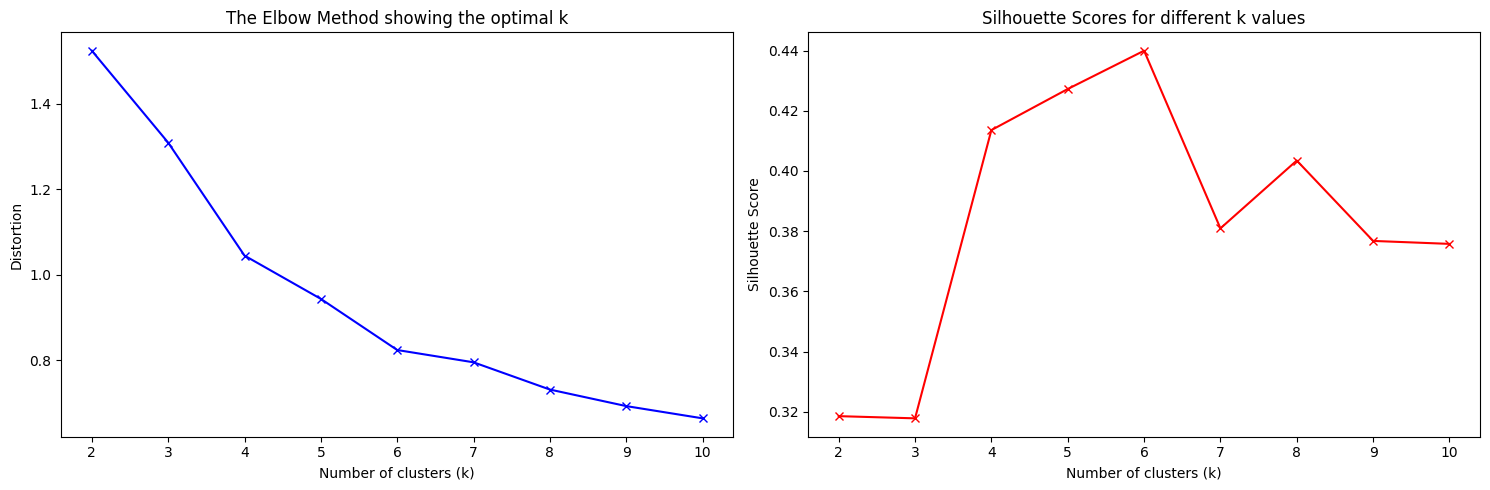


Cluster centers (scaled):
[[-1.33905697  0.47895722 -1.30822992 -1.19644353]
 [ 1.13608207  0.30000651  1.09016516 -1.2547599 ]
 [ 1.06522456 -0.44191719  0.99158305  1.23950275]
 [-0.32003975  1.25526464 -0.26166879 -0.03158663]
 [-1.32157129 -0.95377931 -1.30081415  1.01091344]
 [-0.09982207 -0.8976502  -0.08264686 -0.14976949]]

Cluster distribution:
{0: 21, 1: 33, 2: 39, 3: 44, 4: 25, 5: 38}


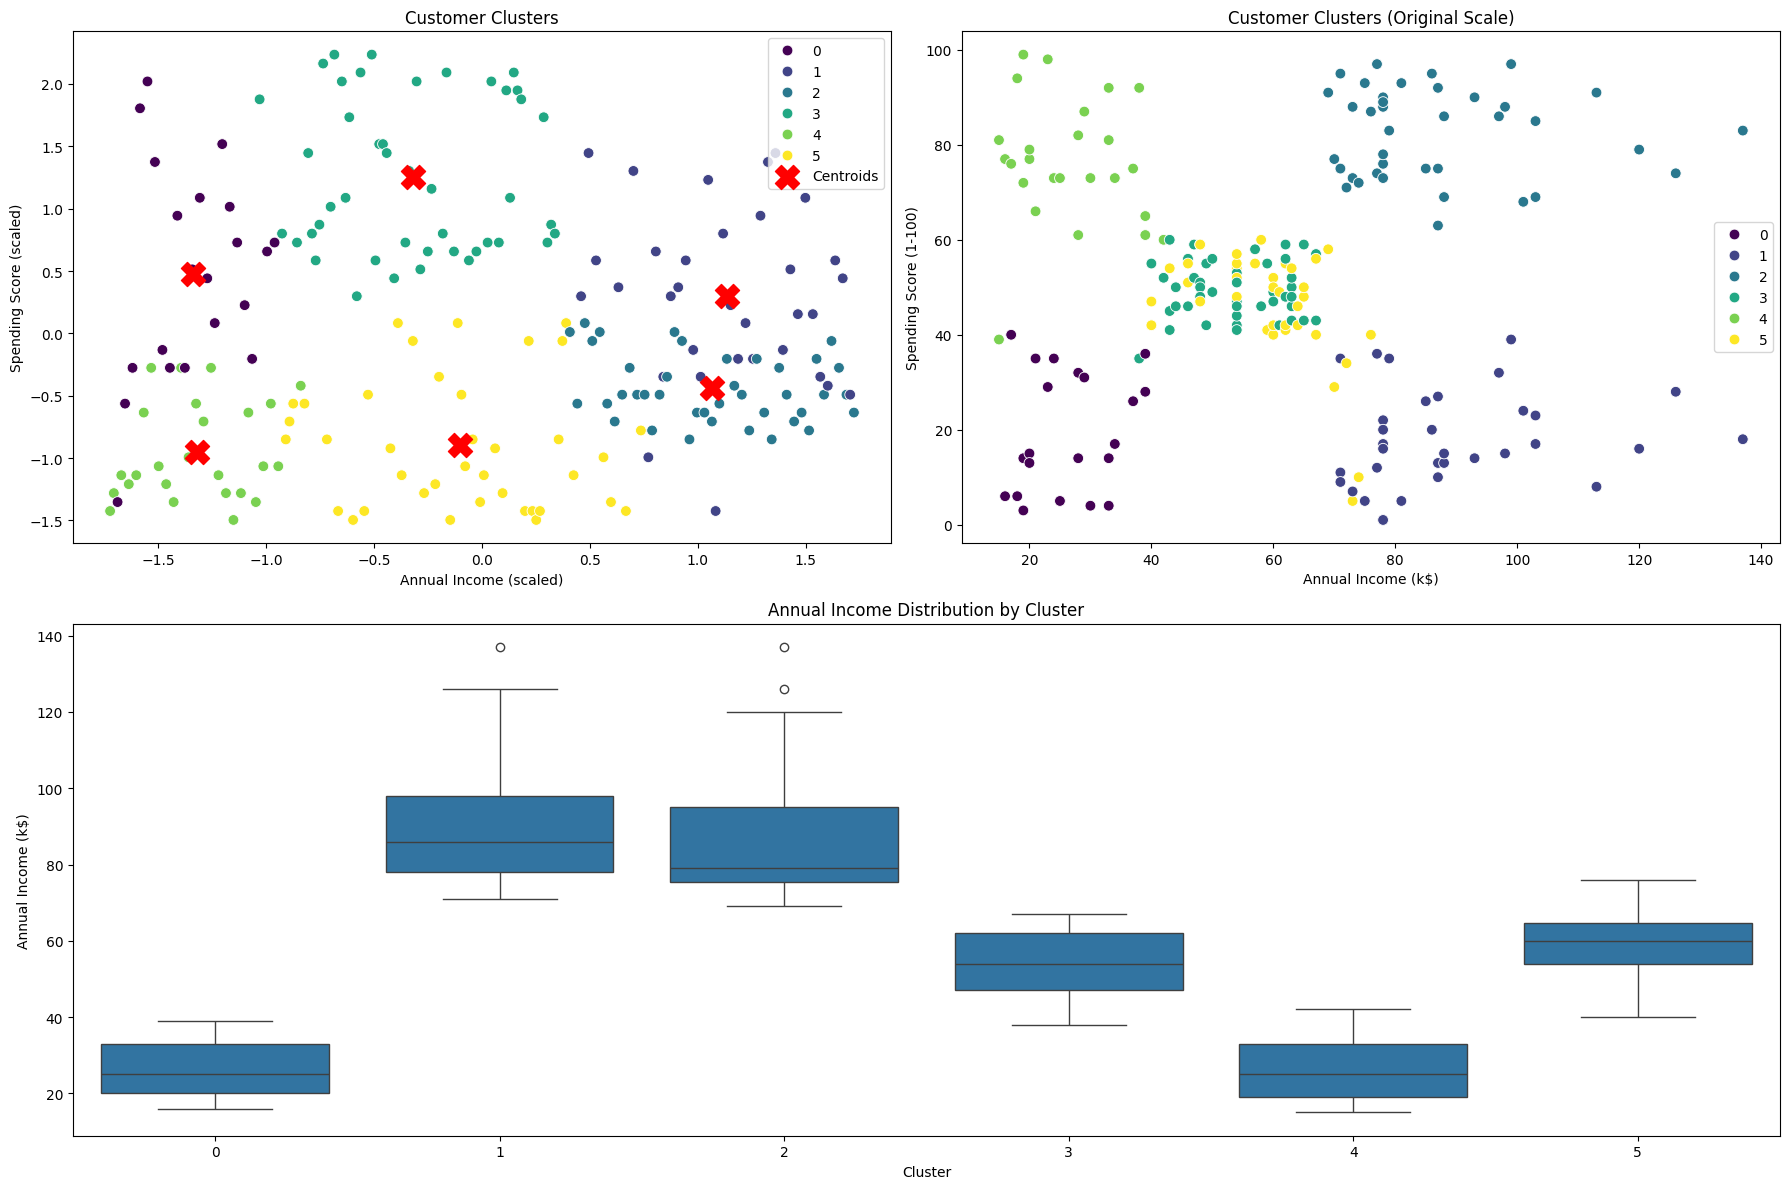


Cluster Profiles:
               Age  Annual Income (k$)  Spending Score (1-100)  Count
Cluster                                                              
0        45.523810           26.285714               19.380952     21
1        43.030303           89.121212               17.878788     33
2        32.692308           86.538462               82.128205     39
3        56.340909           53.704545               49.386364     44
4        25.560000           26.480000               76.240000     25
5        26.342105           58.394737               46.342105     38

Generating pairplot of all features...


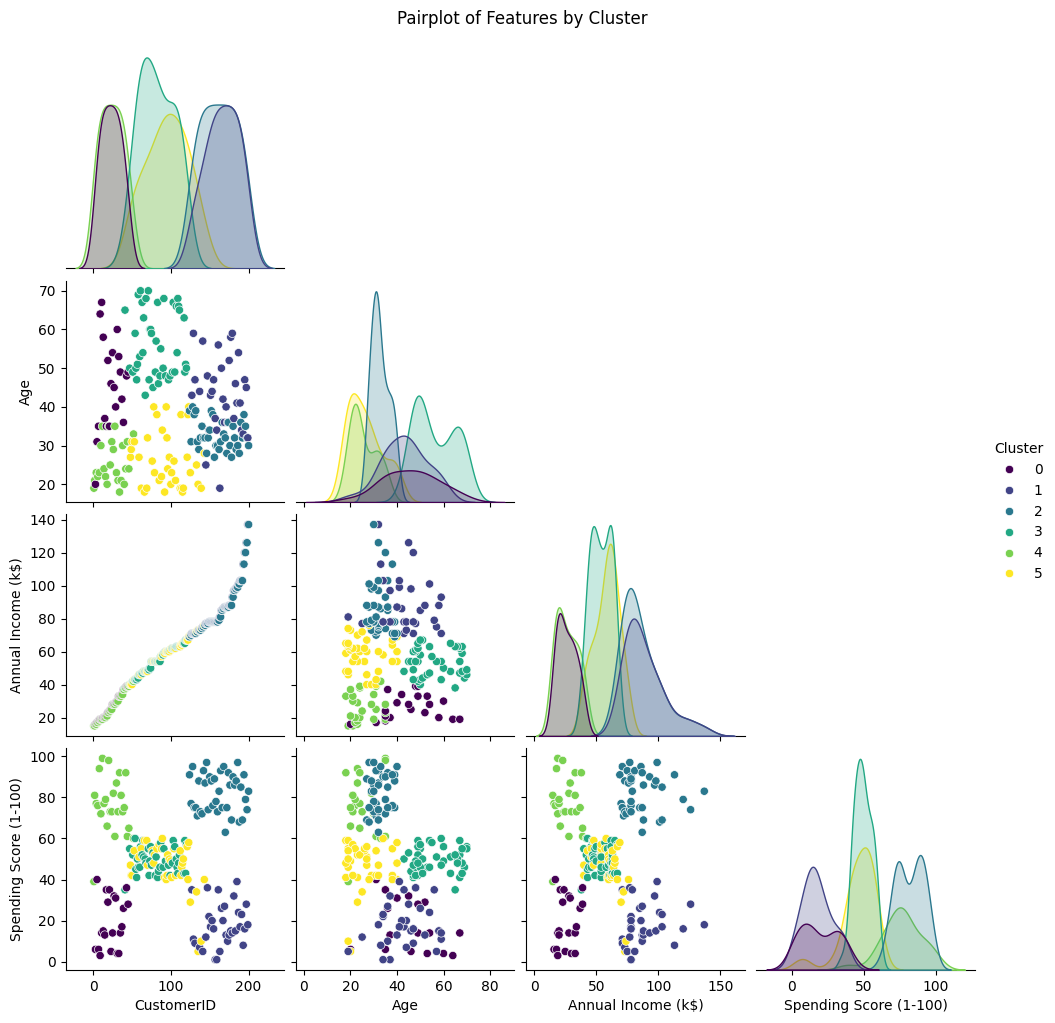

In [35]:
def main():
    """
    Main function to execute the customer segmentation analysis.
    """
  
   
    
    # Step 1: Load and preprocess data
    df, X_scaled = load_and_preprocess_data(url)
    if df is None or X_scaled is None:
        return
    
    # Step 2: Determine optimal number of clusters
    optimal_k, elbow_fig = determine_optimal_clusters(X_scaled)
    print(f"\nOptimal number of clusters: {optimal_k}")
    plt.show(elbow_fig)
    
    # Step 3: Perform clustering with optimal k
    kmeans, labels = perform_clustering(X_scaled, optimal_k)
    if kmeans is None or labels is None:
        return
    
    # Step 4: Visualize clusters
    cluster_viz = visualize_clusters(df, X_scaled, labels, kmeans.cluster_centers_)
    plt.show(cluster_viz)
    
    # Step 5: Analyze cluster profiles
    cluster_profiles = analyze_cluster_profiles(df, labels)
    
    # Additional analysis: Pairplot of all features colored by cluster
    print("\nGenerating pairplot of all features...")
    sns.pairplot(df, hue='Cluster', palette='viridis', corner=True)
    plt.suptitle('Pairplot of Features by Cluster', y=1.02)
    plt.show()

if __name__ == "__main__":
    main()